# Spectroscopic Analysis

In this notebook, we'll walk through the basics of spectroscopy using Python. By the end, you should know how to go from a FITS file with a dispersed 2D spectrum to a 1D line spectrum with relative flux plotted versus wavelegth.

**Please make sure you have already done the bias subtraction and flat-fielding of your raw images before starting this notebook!**

In [22]:
# Import the modules we'll need in this notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm, SymLogNorm
import glob

plt.style.use('~/.mplstyle')

# Ignore annoying astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# For including units on plots below with astropy Quantity objects
from astropy.visualization import quantity_support
quantity_support(); 

In [23]:
datadir = "Sampledata/spectroscopy/"
sciencedir = datadir + 'science/'
calibrationdir = datadir + 'calibration/'
arcfiles = glob.glob(calibrationdir + 'arc/*.fits')
spectrumfile = sciencedir + '/reduced/calibrated.fits'
spectrum = fits.getdata(spectrumfile)

arc_data = [fits.getdata(b).astype(float) for b in arcfiles]  # Read in the arc frames as a list of numpy arrays
arc = np.mean(arc_data, axis=0)  # axis=0 takes the median along the zeroth axis, or the list of images, 
                                  # rather than along the x axes (axis=1) or y axes (axis=2) of the images.

Let's first plot the spectrum, to see what it looks like

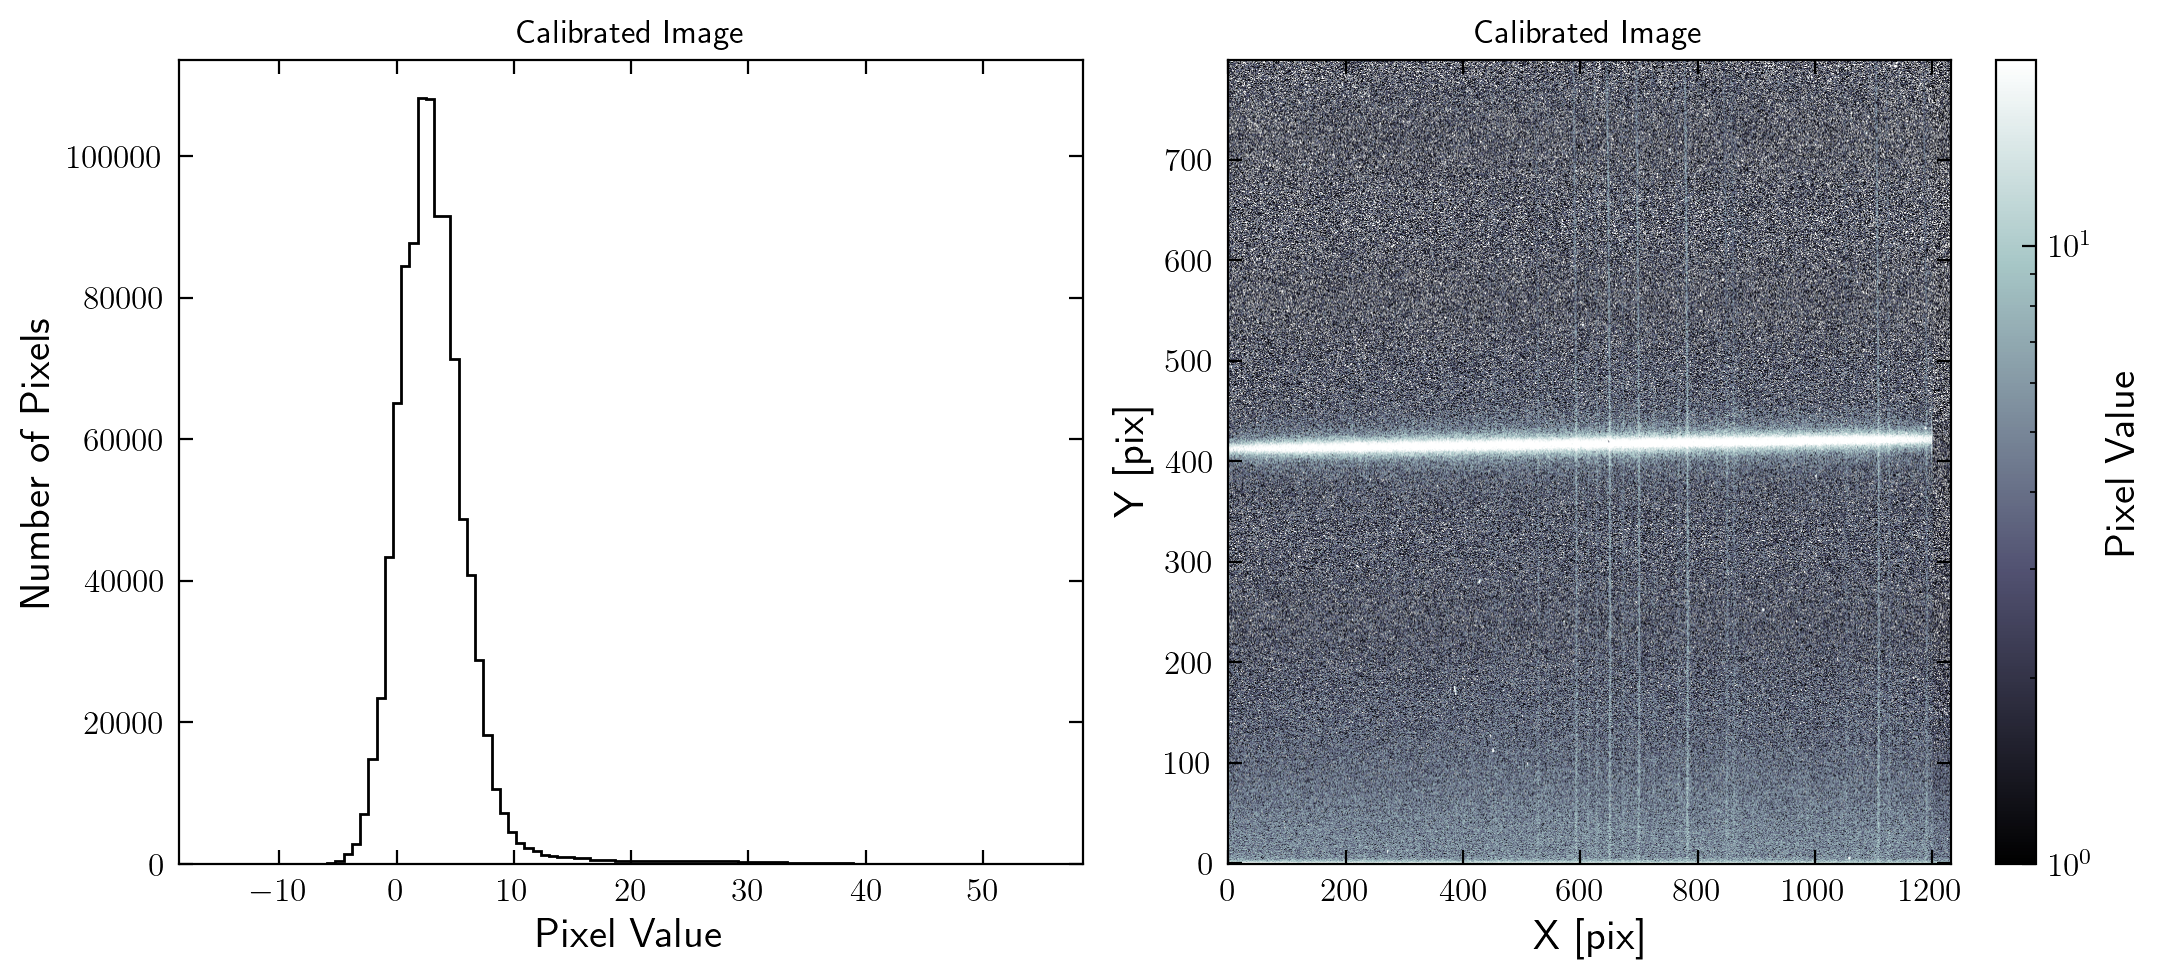

In [24]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# hist = ax1.hist(spectrum.flatten(), bins=100, range=(0,300))
# ax1.set_xlabel("Pixel Value")
# ax1.set_ylabel("Frequency")
# img = plt.imshow(spectrum, cmap='gray', norm=LogNorm(vmin=0.1, vmax=275,), origin='lower')#, cmap=plt.get_cmap('gray'))
# plt.colorbar()

fig, ax = plt.subplots(1, 2, figsize=(11, 5), gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1]})

hist = ax[0].hist(spectrum.flatten(), range=[-15, 55], bins=100, histtype='step', color='black')
ax[0].set_xlabel('Pixel Value')
ax[0].set_ylabel('Number of Pixels')
ax[0].set_title('Calibrated Image')

img = plt.imshow(spectrum, cmap='bone', norm=LogNorm(vmin=1, vmax=20), origin='lower', aspect='auto')
ax[1].set_xlabel('X [pix]')
ax[1].set_ylabel('Y [pix]')
ax[1].set_title('Calibrated Image')

fig.colorbar(img, ax=ax[1], label='Pixel Value')
fig.tight_layout()

## Spectroscopy-specific corrections

<!---Our spectrum is clearly visible around the y=300pix row. However, it appears to have quite a bit of noise...you can see bright lines that span the entire image, not just where our spectrum is -- these are sky lines! They are noise, so we need to subtract them out. We'll do that by subtracting the median value for each column from the value for each pixel in that column.--->

The first thing we'll need to check is that our spectrum is exactly aligned along the dispersion (x) direction and that it is confined to a constant y range on the image. We want to ensure that each x value corresponds to one specific wavelength and that there is no slanting or curvature in the spectrum. To do this:

1. Load the image into [DS9](http://ds9.si.edu/site/Download.html) and adjust the color scaling so you can see your spectrum. 
2. Place your cursor at one end of the spectrum, at the top of the brightest area of the spectrum. Note the (X,Y) position
3. Move your cursor along the top of the spectrum and note ~10 (X,Y) data points along the way
4. If there is a difference *anywhere*\* of 10+ pixels, you should perform the correction detailed in the next few cells

    \* This includes from start to end (indicative of a slanting spectrum) or from one end to the middle (indicative of a curved spectrum)
    
Let's first plot a scatter plot of our (X,Y) data to see what it looks like.

Text(0, 0.5, 'Pixel, y-dir')

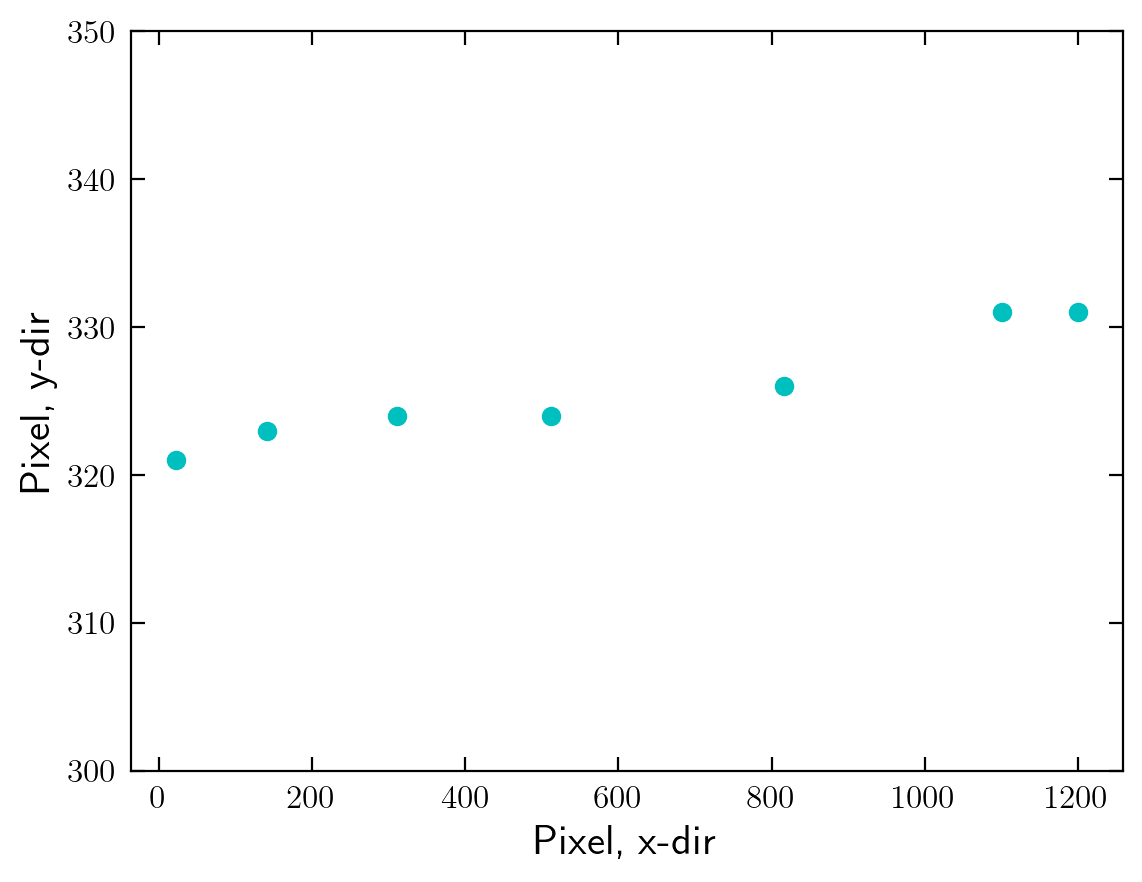

In [25]:
curvecorrect_top = [(1199,331),(1101,331),(816,326),(512,324),(311,324),(142,323),(22.5,321)]
x_top, y_top = zip(*curvecorrect_top)

plt.scatter(x_top, y_top, color='c')
plt.ylim(300,350)
plt.xlabel("Pixel, x-dir")
plt.ylabel("Pixel, y-dir")

Okay, there's a slight slant. Not too bad, but we should still correct it. The approach will be

1. Fit a curve to the data. Whether you fit a linear curve or some higher order polynomial will depend on how the data looks to you. We will be fitting a linear line for this exercise.
2. Choose a value to be the fixed width of your spectrum slice. We won't need the entire vertical width of the spectrum in order to extract our science. 10 pixels is usually sufficient.
3. For each X value, use your fitted curve to calculate the corresponding Y value. This will give you the Y value of the top of the spectrum. I recommend subtracting 5 pixels from this value in order to ensure you are fully inside the spectrum light.
4. Copy the values of the pixels between (Y-5) and (Y-15) into a new array. You should end up with a [len(X-dim)$ \times 10$] array.
5. Repeat #4 for a region away from the spectrum to create a background array. You could do this by adding 50 pixels to the Y values instead of subtracting 5 pixels.

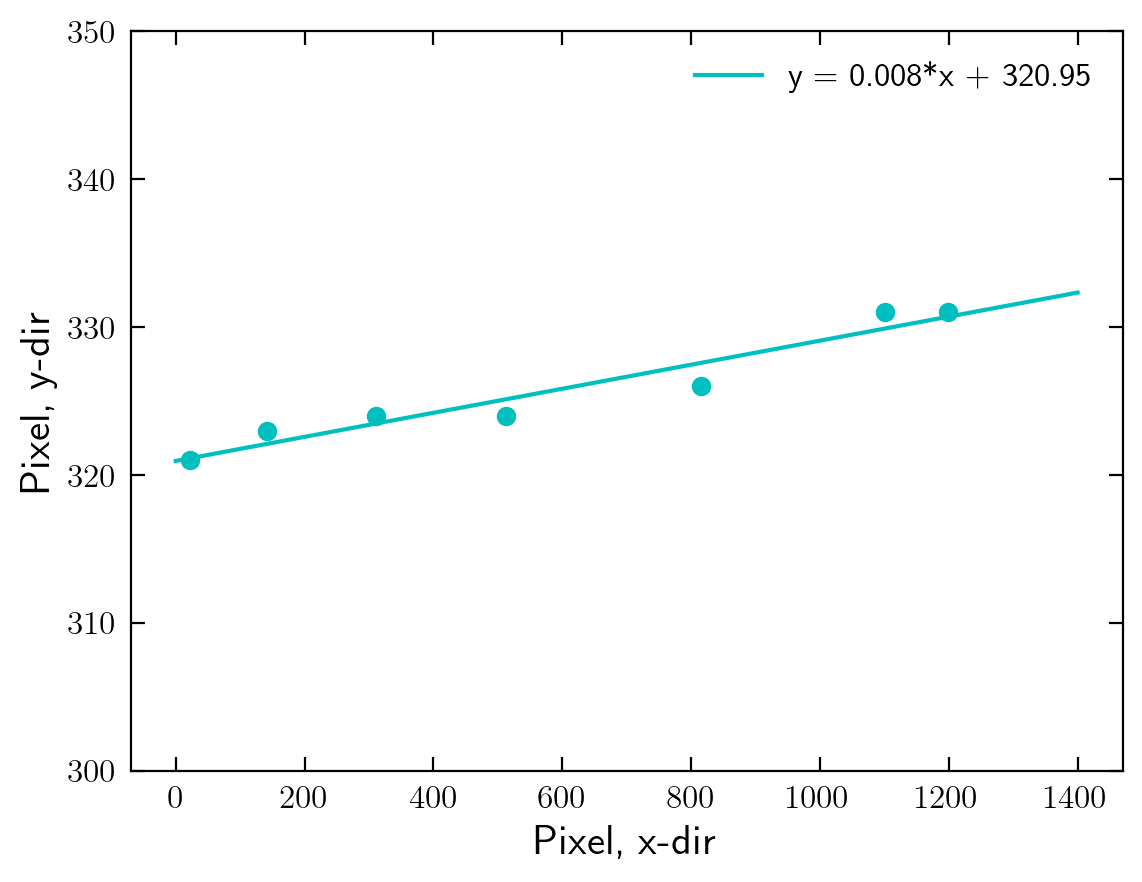

In [26]:
# Fit a line to our (X,Y) data
def linear_fit(x, *params):
    m, b = params
    return m*x + b

init = [1.0, 300.]
coeff, covar = curve_fit(linear_fit, x_top, y_top, p0=init)
x_fit = np.linspace(0,1400,1000)
y_fit = linear_fit(x_fit, *coeff)
label_str = "y = %.3f*x + %.2f" % (coeff[0], coeff[1])

plt.scatter(x_top, y_top, color='c')
plt.plot(x_fit, y_fit, color='c', label=label_str)
plt.ylim(300,350)
plt.xlabel("Pixel, x-dir")
plt.ylabel("Pixel, y-dir")
plt.legend()

In [27]:
x_pix = np.asarray([i for i in range(1200)]) 
y_pix = np.floor(linear_fit(x_pix, coeff[0], coeff[1])).astype(int)  # to ensure our pixel number is an int

# Arrays of length len(x_pix)
target_upper = y_pix - 5
target_lower = y_pix - 15
sky_upper = y_pix + 50
sky_lower = y_pix + 40

# Extract slices corresponding to the target spectrum and sky background
target = np.asarray(
            [spectrum.T[i, target_lower[i]:target_upper[i]] 
             for i in range(1200)]
           ).T

sky = np.asarray(
         [spectrum.T[i, sky_lower[i]:sky_upper[i]] 
          for i in range(1200)]
        ).T

In [28]:
# Subtract sky background from target
column_medians = np.median(sky, axis=0)
target_skysub = target - column_medians

Text(0, 0.5, 'Counts')

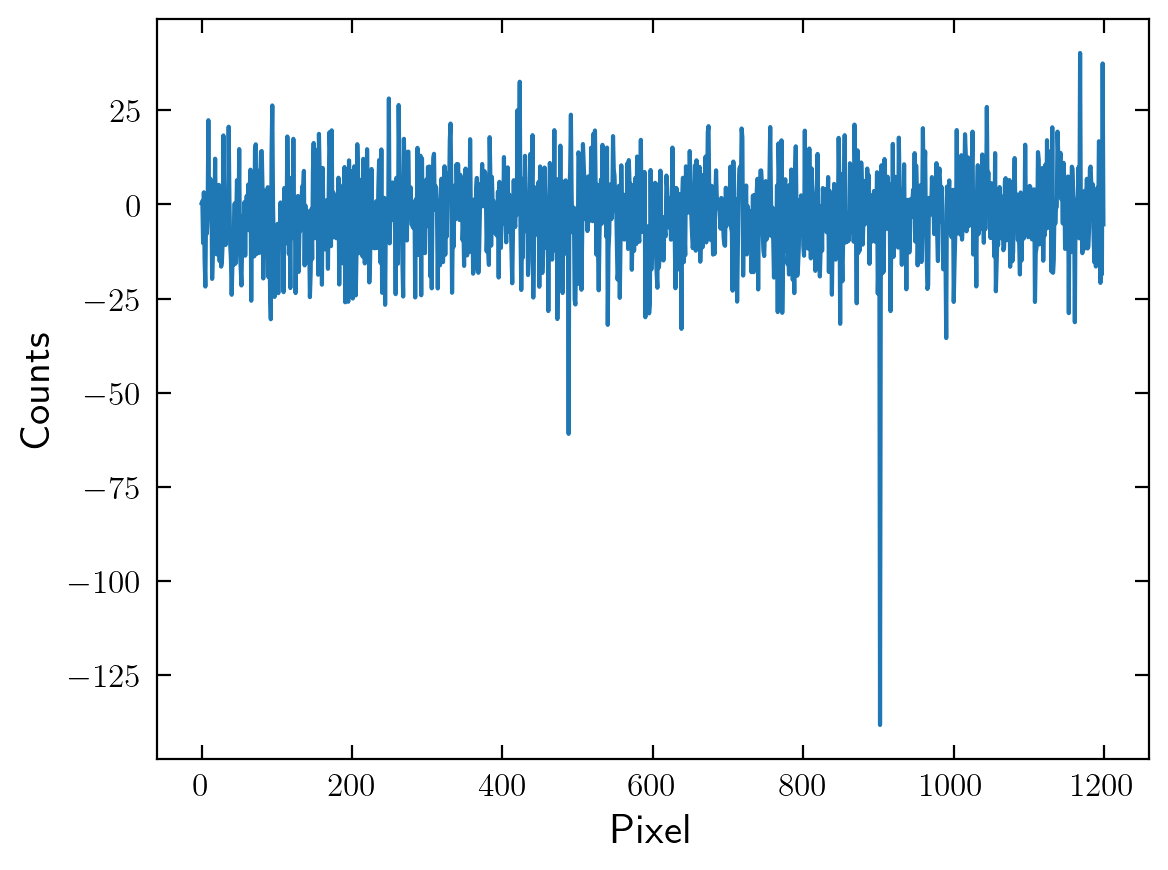

In [29]:
target_skysub_1d = np.sum(target_skysub, axis=0)
target_skysub_1d = target_skysub_1d[::-1]  # plot the spectrum correctly, i.e. blue to the left
plt.plot(x_pix, target_skysub_1d)
plt.xlabel("Pixel")
plt.ylabel("Counts")

## From Pixels to Wavelengths

The calibration arc file allows us to convert from image pixels to wavelengths. A noble gas lamp with well-known spectral lines is used to perform this calibration. Our calibration arc file made use of an argon and mercury lamp.

[   0 1027 1125]


Text(0, 0.5, 'Counts')

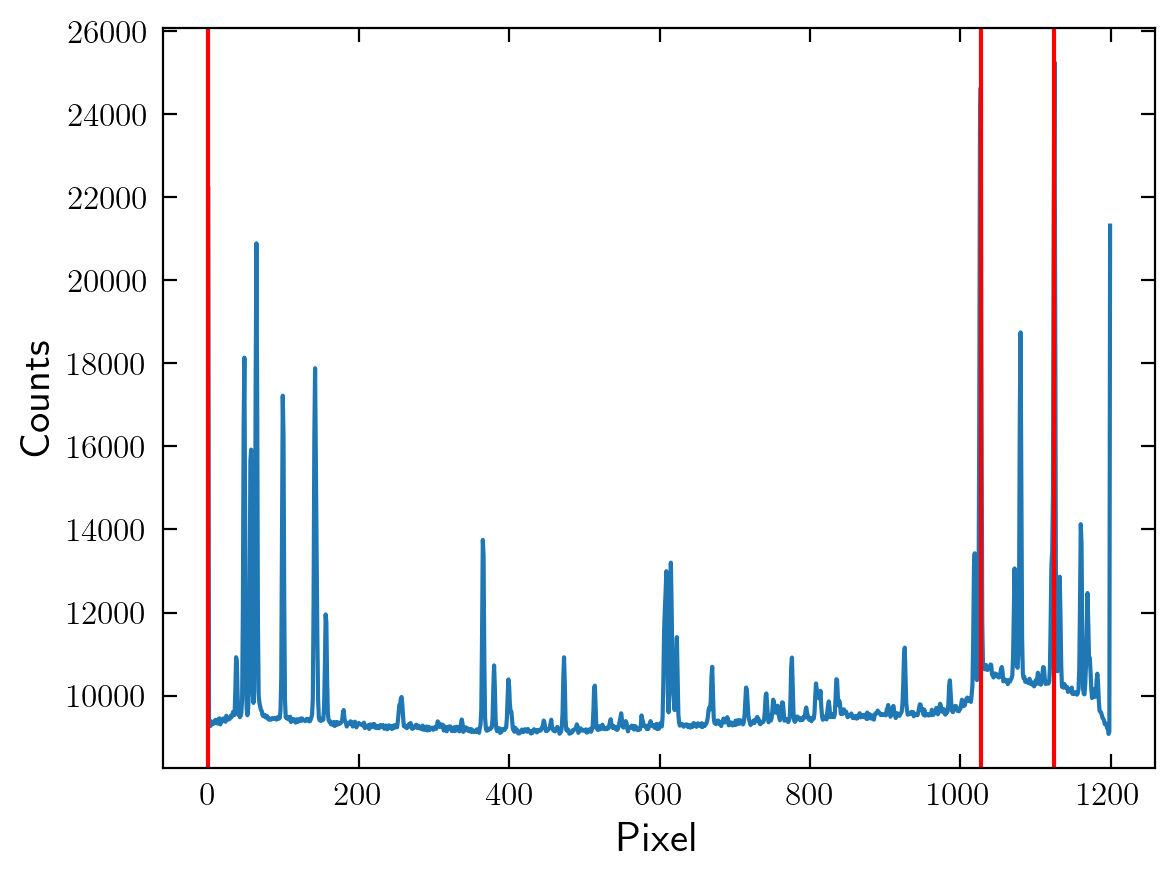

In [30]:
# Get a section of the arc image
# Don't need to use whole thing!
# Choose a region that seems relatively clean
arc_slice = arc[300:350, :1200]
arc_slice_1d = np.sum(arc_slice, axis=0)
arc_slice_1d = arc_slice_1d[::-1]  # again, put bluer wavelengths toward the left

# Find the peaks by setting a threshold
peaks = np.where(arc_slice_1d > 21000)[0]

# Some peaks also have pixels to either side that exceed the threshold
# We will take just the rightmost pixel for now
# Not 100% accurate, but okay for now
unique_peaks = peaks[np.where((peaks[1:] - peaks[:-1]) > 1)]

print(unique_peaks)
plt.plot(x_pix, arc_slice_1d)
for j in unique_peaks:
    plt.axvline(j, color='r')
plt.xlabel("Pixel")
plt.ylabel("Counts")

Compare to NIST data ![](ccds_calibration_lamps/ar_blue3.png)

Hmm, that cluster around 550nm or so looks a lot like the cluster around pixels 300-400 in our calibration image...

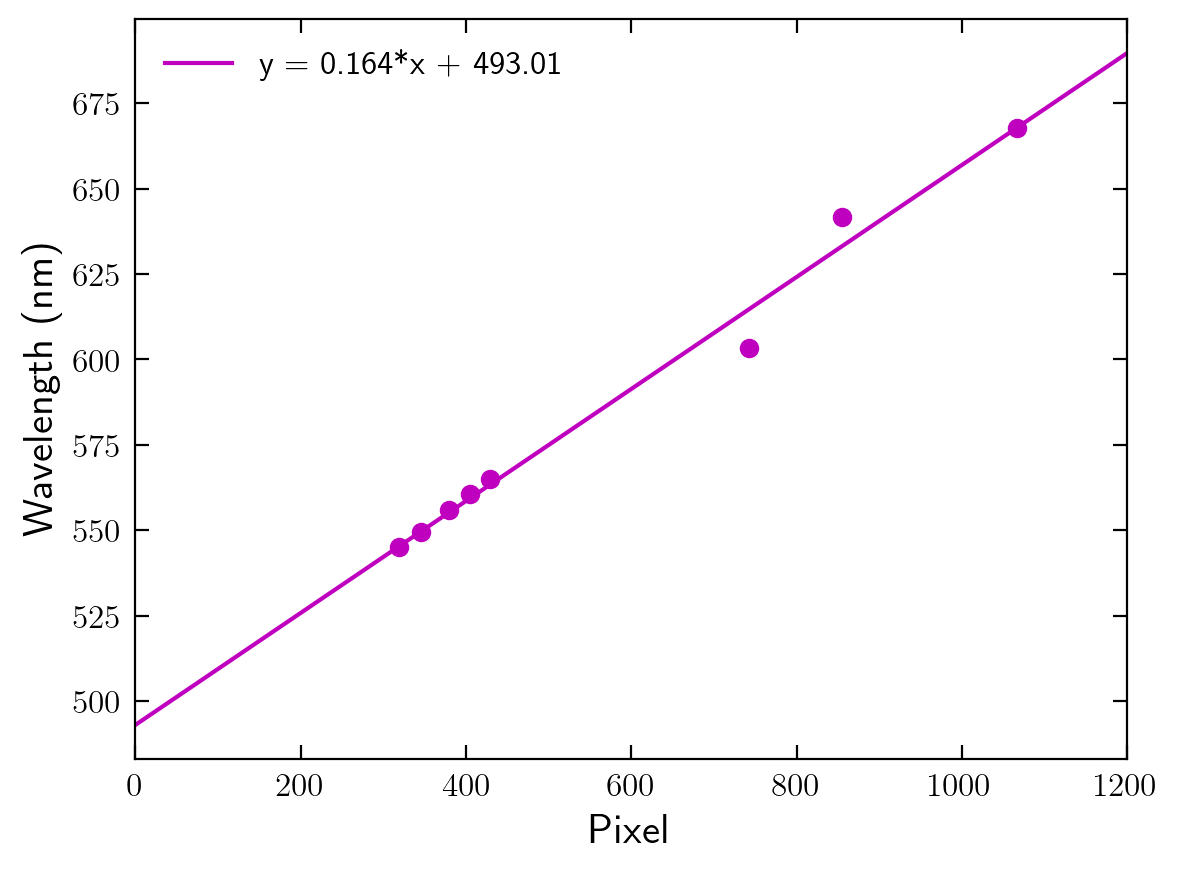

In [31]:
arc_pixels = [319, 346, 380, 405, 429, 742, 855, 1066]
arc_wavelengths = [545.1, 549.5, 555.8, 560.6, 565.0, 603.2, 641.6, 667.7]

# Fit a linear line to create a mapping between pixels and wavelengths
arc_init = [3, 500.0]
arc_coeff, arc_covar = curve_fit(linear_fit, arc_pixels, arc_wavelengths, p0=arc_init)
pix_fit = np.linspace(0,1200,1000)
wavelength_fit = linear_fit(pix_fit, *arc_coeff)
label_str = "y = %.3f*x + %.2f" % (arc_coeff[0], arc_coeff[1])

plt.scatter(arc_pixels, arc_wavelengths, color='m')
plt.plot(pix_fit, wavelength_fit, color='m', label=label_str)
plt.xlim(0,1200)
plt.xlabel("Pixel")
plt.ylabel("Wavelength (nm)")
plt.legend(loc=2)

Text(0, 0.5, 'Counts')

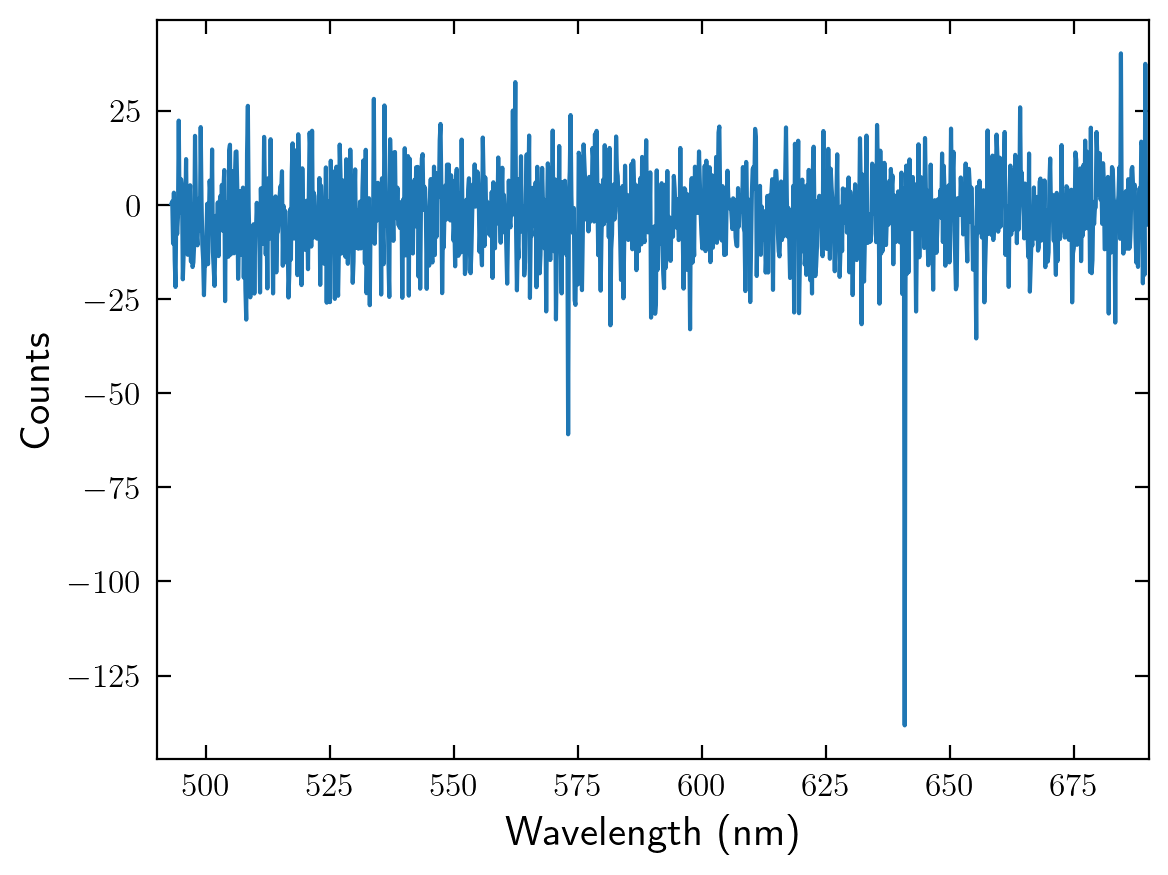

In [32]:
x_wavelengths = linear_fit(x_pix, *arc_coeff)

plt.plot(x_wavelengths, target_skysub_1d)
plt.xlim(490,690)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Counts")

# Using `specutils` to analyze the spectrum

Now we have our 1D spectrum, we can use `specutils` to analyze it! The package contains a variety of helpful functions -- we'll walk through some of them here, but I encourage you to look through the [documentation](https://specutils.readthedocs.io) to see everything `specutils` can do.

## The `Spectrum1D` object and continuum fitting

The `Spectrum1D` function is a class to hold the information about a spectrum. To initialize, it requires inputs to be `astropy.Quantity` objects, which essentially means they have units. We'll use units of nanometers and counts here.

Text(0, 0.5, 'Counts')

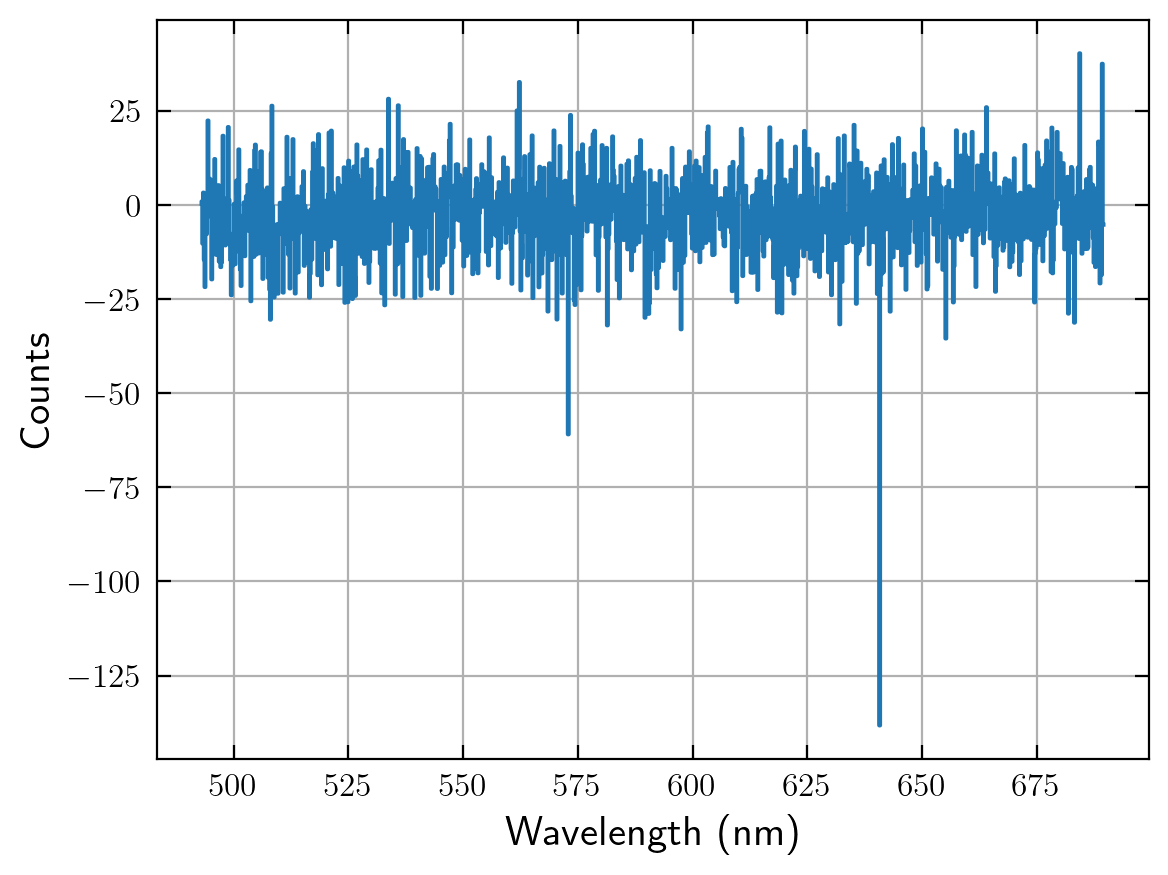

In [33]:
import specutils
import astropy.units as u

spec = specutils.Spectrum1D(spectral_axis=x_wavelengths*u.nm, flux=target_skysub_1d*u.count)
plt.step(spec.spectral_axis, spec.flux)
plt.grid()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Counts")

With the help of the grid, we see that the continuum isn't exactly flat -- we need to perform some continuum fitting! `specutils` provides a function for that

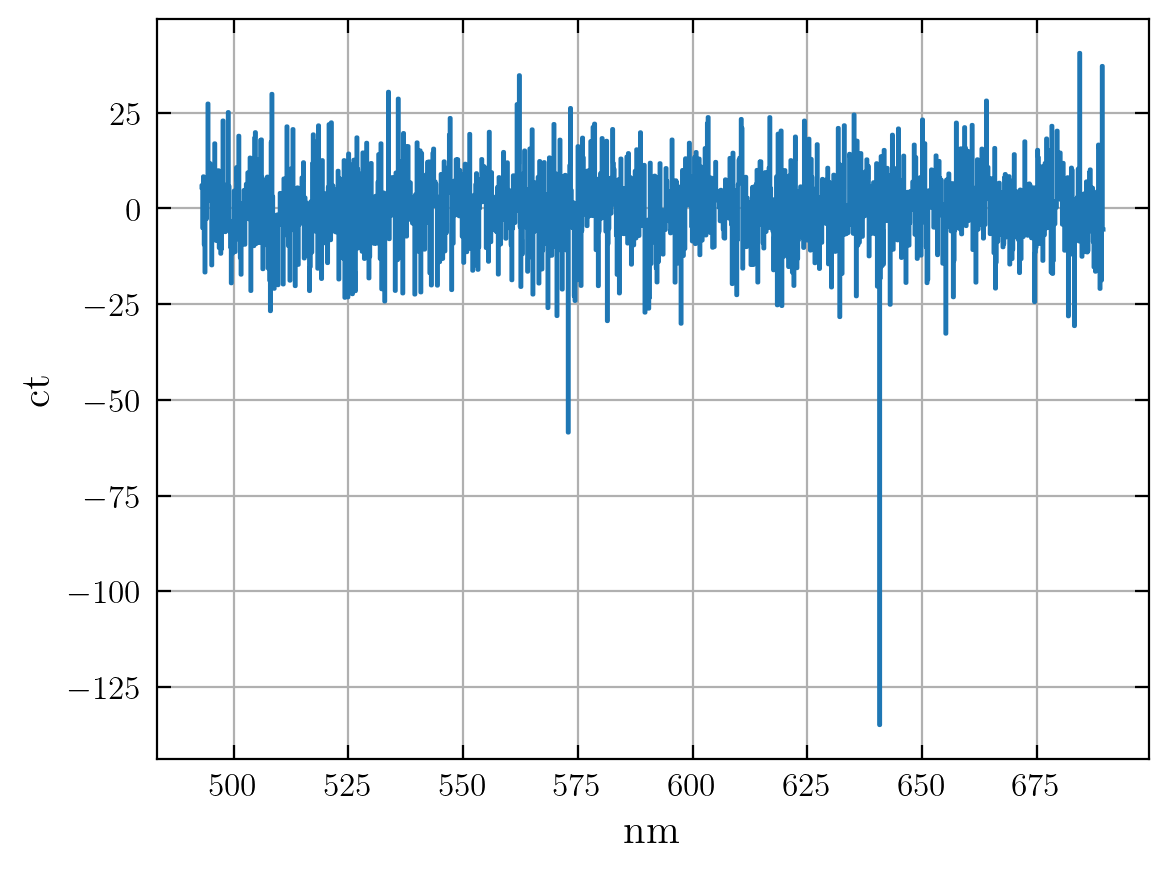

In [34]:
from specutils.fitting import fit_generic_continuum
from astropy.modeling import models
from astropy.modeling.fitting import LevMarLSQFitter
# need to take u.nm unit out of window
cont = fit_generic_continuum(spec, fitter=LevMarLSQFitter(), model=models.Polynomial1D(1,c0=100, c1=-0.1, window=[500, 675]))
cont.input_units_equivalencies = {'x': u.spectral()}
cont = fit_generic_continuum(spec)

spec_contsub = spec - cont(spec.spectral_axis)#fit_generic_continuum(spec)(spec.spectral_axis) # subtract the continuum, noise will be ~0

plt.step(spec_contsub.wavelength.to(u.nm), spec_contsub.flux)  
plt.grid()

We now have a spectrum that's ready to go! 

## Analysis of the Spectrum

The first thing we need to do is actually find the lines in the spectrum. We'll first tell `specutils` what our noise looks like using the `noise_region_uncertainty` function. Then we'll search for lines by looking for changes in derivatives of the spectrum, specifying the flux threshold we consider a source.

In [35]:
from specutils.manipulation import noise_region_uncertainty, extract_region

noise_region = specutils.SpectralRegion(550*u.nm, 575*u.nm)
spec_contsub_noiseest = noise_region_uncertainty(spec_contsub, noise_region)

line_center line_type line_center_index
     nm                                
----------- --------- -----------------


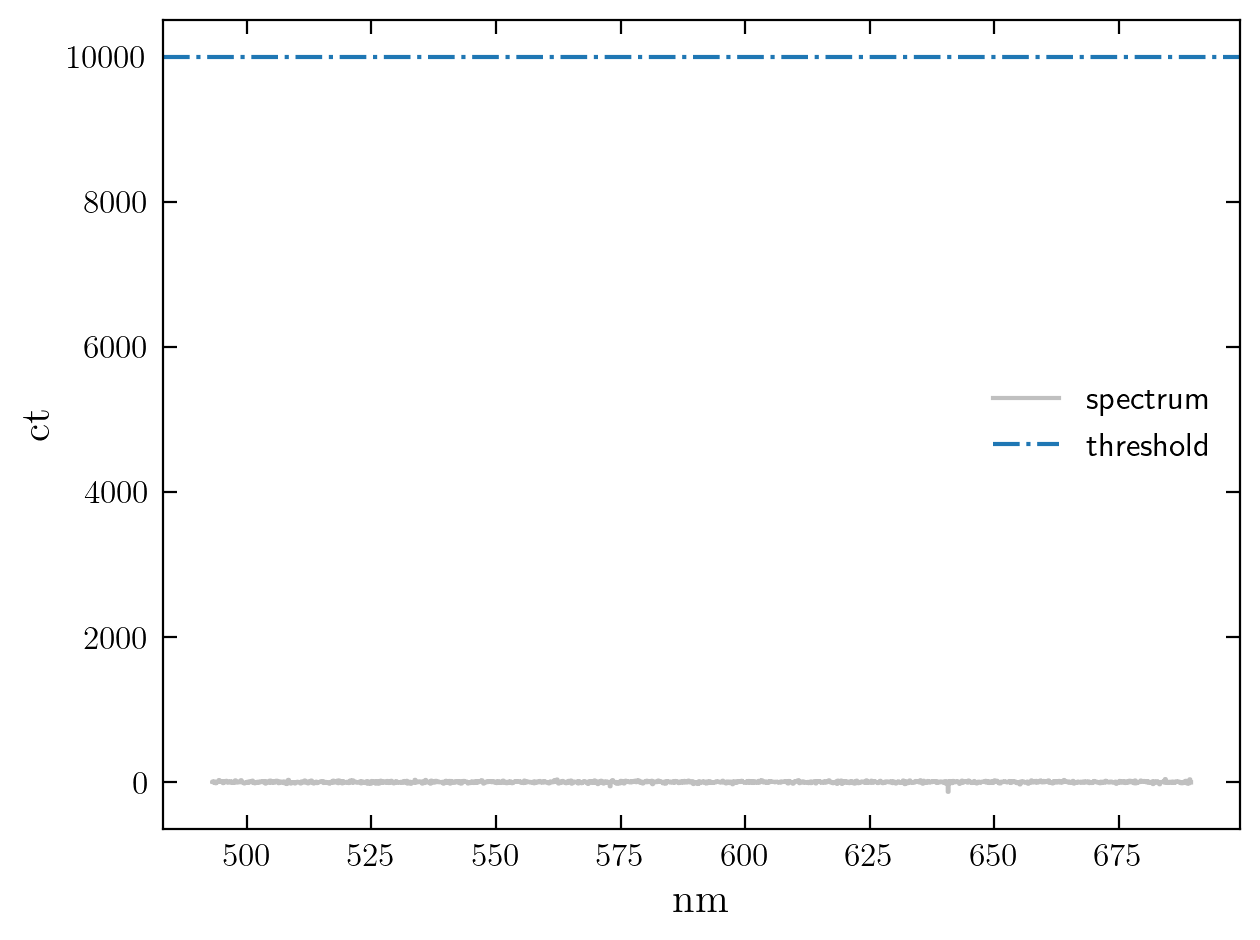

In [36]:
from specutils.fitting import find_lines_derivative

# Find lines in the spectrum using derivatives and flux value
threshold = 10000 # Choose this threshold based on your own spectrum
lines = find_lines_derivative(spec_contsub_noiseest, flux_threshold=threshold) 
print(lines)

# Plot the spectrum, threshold, and detected lines
plt.step(spec_contsub_noiseest.wavelength.to(u.nm), spec_contsub_noiseest.flux, 
         color='silver', label='spectrum')
labeled = False
for j in lines['line_center']:
    j = j.value
    if not labeled:
        plt.axvline(j, ymin=0, color='C1', ls='--', label='peaks')
        labeled=True
    else:
        plt.axvline(j, color='C1', ls='--')
plt.axhline(threshold, color='C0', ls='-.', label='threshold')     
plt.legend()
plt.tight_layout()

Let's zoom in on both of these regions, using `SpectralRegion` and `extract_region`

In [37]:
lines

line_center,line_type,line_center_index
nm,,
float64,float64,float64


IndexError: index 0 is out of bounds for axis 0 with size 0

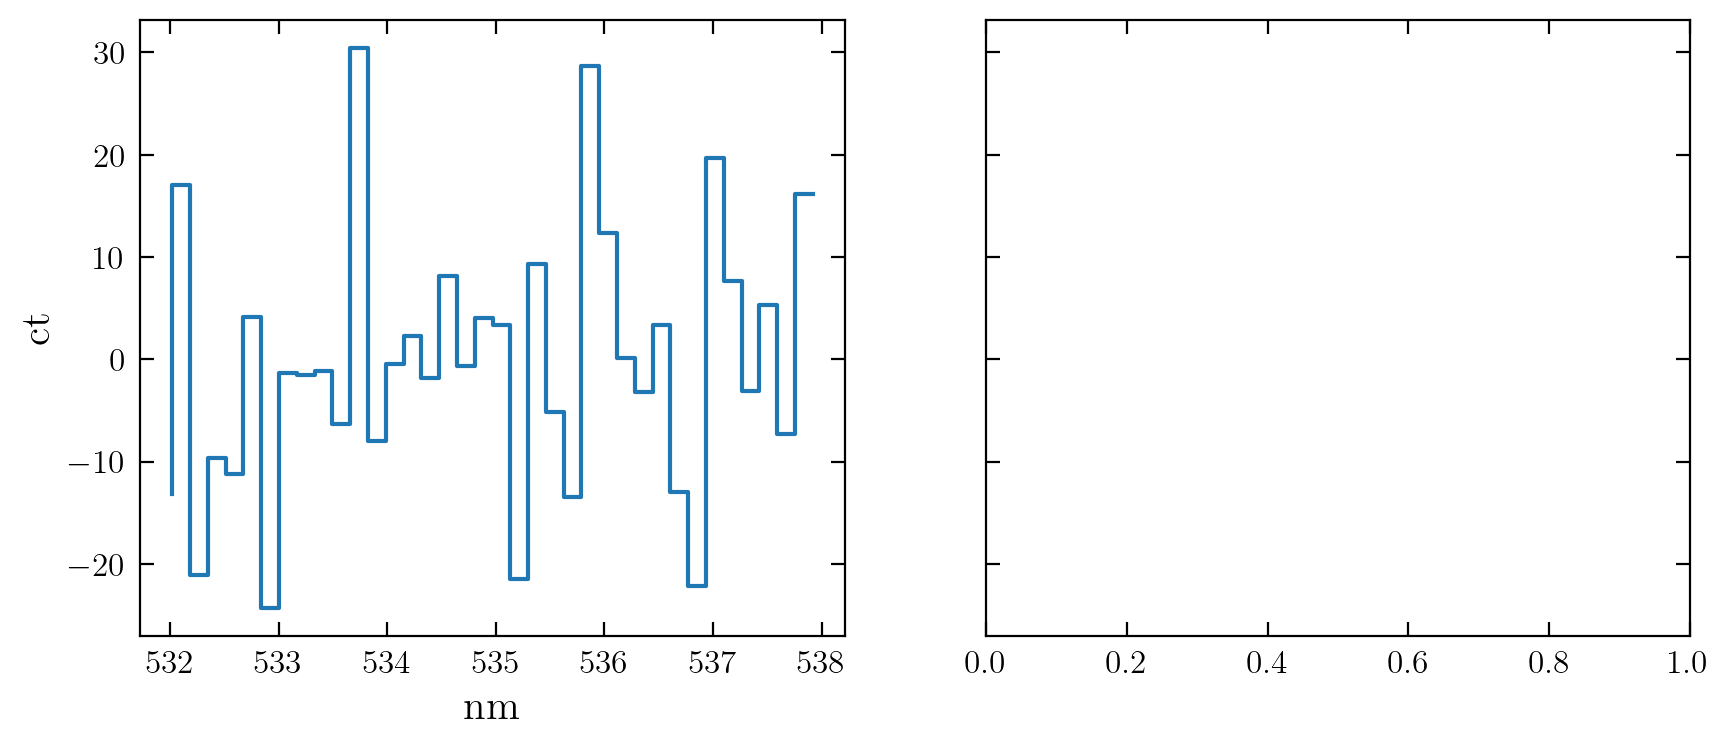

In [38]:
fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)  
    
# Plot the region of the first peak
peak1 = specutils.SpectralRegion(532*u.nm, 538*u.nm)
peak1_spec = extract_region(spec_contsub_noiseest, peak1)
axes[0].step(peak1_spec.wavelength.to(u.nm), peak1_spec.flux)
axes[0].axvline(lines['line_center'][0].value, color='orange')
axes[0].set_title('First Peak')

# Plot the region of the second peak (which is actually two peaks!)
peak23 = specutils.SpectralRegion(640*u.nm, 650*u.nm)
peak23_spec = extract_region(spec_contsub_noiseest, peak23)
axes[1].step(peak23_spec.wavelength.to(u.nm), peak23_spec.flux)
for j in lines['line_center'][1:]:
    j = j.value
    axes[1].axvline(j, color='C1')
axes[1].set_title('Second Set of Peaks')

plt.tight_layout()

### Peak #1

Let's look at the single peak first. We can get a bunch of quick information about it using the `specutils.analysis` module.

In [39]:
import specutils.analysis as an

print('Centroid:        {0:0.03f}'.format(an.centroid(peak1_spec, region=peak1)))
print('FWHM:            {0:0.03f}'.format(an.fwhm(peak1_spec, regions=peak1)))
print('Gaussian FWHM:   {0:0.03f}'.format(an.gaussian_fwhm(peak1_spec, regions=peak1)))
print('Gaussian width:  {0:0.03f}'.format(an.gaussian_sigma_width(peak1_spec, regions=peak1)))
print('Integrated flux: {0:0.03f}'.format(an.line_flux(peak1_spec, regions=peak1)))
print('SNR:             {0:0.03f}'.format(an.snr(peak1_spec, region=peak1)))

Centroid:        525.176 nm
FWHM:            0.133 nm
Gaussian FWHM:   nan nm
Gaussian width:  nan nm
Integrated flux: -2.902 ct nm
SNR:             -0.040


/opt/anaconda3/envs/astro461/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Now let's get a little fancier and do some more sophisticated line fitting

In [40]:
from astropy.modeling import models
from specutils.fitting import estimate_line_parameters, fit_lines

# Get an estimate for the parameters of the Gaussian
param_estimate = estimate_line_parameters(peak1_spec, models.Gaussian1D())
print('**Parameter estimate**')
print('Amplitude:  {0:0.03f}   Mean: {1:0.03f}   Std dev: {2:0.03f}'
      .format(param_estimate.amplitude.quantity, 
              param_estimate.mean.quantity, 
              param_estimate.stddev.quantity))

# Use the estimated parameters to inform the fitted Gaussian
g_init = models.Gaussian1D(amplitude=param_estimate.amplitude, 
                           mean=param_estimate.mean, 
                           stddev=param_estimate.stddev)
g_fit = fit_lines(peak1_spec, g_init)
y_fit = g_fit(peak1_spec.spectral_axis)

print('\n**Parameter fit**')
print('Amplitude:  {0:0.03f}   Mean: {1:0.03f}   Std dev: {2:0.03f}   FWHM: {3:0.03f}'
      .format(g_fit.amplitude.quantity, 
              g_fit.mean.quantity, 
              g_fit.stddev.quantity,
              g_fit.fwhm))

plt.plot(peak1_spec.spectral_axis, peak1_spec.flux, color='silver', label='original spectrum')
plt.plot(peak1_spec.spectral_axis, y_fit, label='fitted spectrum')
plt.legend();

**Parameter estimate**
Amplitude:  30.468 ct   Mean: 525.176 nm   Std dev: nan nm


ValueError: Initial guess is outside of provided bounds

### Peak #2 (which is actually two peaks)
Now let's look at the set of double peaks. `specutils` can also easily handle this case in a variety of ways.

In [41]:
# Fit each peak
gl_init = models.Gaussian1D(amplitude=1200*u.count, mean=lines['line_center'][1], stddev=0.25*u.nm)
gr_init = models.Gaussian1D(amplitude=2500*u.count, mean=lines['line_center'][2], stddev=0.5*u.nm)

glr_fit = fit_lines(peak23_spec, gl_init+gr_init)
ylr_fit = glr_fit(peak23_spec.spectral_axis)

print('**Parameter fit**')
print('LEFT PEAK  -- Amplitude:  {0:0.03f}   Mean: {1:0.03f}   Std dev: {2:0.03f}'
      .format(glr_fit.amplitude_0.quantity, 
              glr_fit.mean_0.quantity, 
              glr_fit.stddev_0.quantity))
print('RIGHT PEAK -- Amplitude:  {0:0.03f}   Mean: {1:0.03f}   Std dev: {2:0.03f}'
      .format(glr_fit.amplitude_1.quantity, 
              glr_fit.mean_1.quantity, 
              glr_fit.stddev_1.quantity))

plt.plot(peak23_spec.spectral_axis, peak23_spec.flux, color='silver', label='original spectrum')
plt.plot(peak23_spec.spectral_axis, ylr_fit, label='fitted spectrum')
plt.legend();

IndexError: index 1 is out of bounds for axis 0 with size 0

Let's look at each peak individually. We can still use the same models as above, but we'll change how arguments are passed to `fit_lines` to pick out one peak or the other. 

In particular, instead of passing `gl_fit+gr_fit` as an argument, we'll pass them as a list `[gl_init, gr_init]`, which means they will be evaluated separately. Furthermore, we'll pass a `window` argument to let the code know which region each model should be fit to.

In [42]:
peak2 = specutils.SpectralRegion(642*u.nm, 644*u.nm)
peak3 = specutils.SpectralRegion(644*u.nm, 646.5*u.nm)

gl_fit, gr_fit = fit_lines(peak23_spec, [gl_init, gr_init], 
                           window=[peak2, peak3])
yl_fit = gl_fit(peak23_spec.spectral_axis)
yr_fit = gr_fit(peak23_spec.spectral_axis)

print('**Parameter fit**')
print('LEFT PEAK  -- Amplitude:  {0:0.03f}   Mean: {1:0.03f}   Std dev: {2:0.03f}   FWHM: {3:0.03f}'
      .format(gl_fit.amplitude.quantity, 
              gl_fit.mean.quantity, 
              gl_fit.stddev.quantity,
              gl_fit.fwhm))
print('RIGHT PEAK -- Amplitude:  {0:0.03f}   Mean: {1:0.03f}   Std dev: {2:0.03f}   FWHM: {3:0.03f}'
      .format(gr_fit.amplitude.quantity, 
              gr_fit.mean.quantity, 
              gr_fit.stddev.quantity,
              gr_fit.fwhm))

plt.plot(peak23_spec.spectral_axis, peak23_spec.flux, color='silver',label='original spectrum')
plt.plot(peak23_spec.spectral_axis, yl_fit, label='fitted spectrum, left peak')
plt.plot(peak23_spec.spectral_axis, yr_fit, label='fitted spectrum, right peak')
plt.legend();

NameError: name 'peak23_spec' is not defined

In [43]:
print("| %-15s | %-11s    | %-11s    |" % ("Parameter","Left Peak", "Right Peak"))
print("-"*53)

print('| {0:15s} | {1:8.3f}    | {2:8.3f}    |'.format("Centroid",
                                                       *an.centroid(peak23_spec, 
                                                                    region=[peak2, peak3])))
print('| {0:15s} | {1:8.3f}    | {2:8.3f}    |'.format("FWHM",
                                                       *an.fwhm(peak23_spec, 
                                                                regions=[peak2, peak3])))
print('| {0:15s} | {1:8.3f}    | {2:8.3f}    |'.format("Gaussian FWHM",
                                                       *an.gaussian_fwhm(peak23_spec, 
                                                                        regions=[peak2, peak3])))
print('| {0:15s} | {1:8.3f}    | {2:8.3f}    |'.format("Gaussian width",
                                                       *an.gaussian_sigma_width(peak23_spec, 
                                                                                regions=[peak2, peak3])))
print('| {0:15s} | {1:8.3f} | {2:8.3f} |'.format("Integrated flux",
                                                 *an.line_flux(peak23_spec, 
                                                               regions=[peak2, peak3])))
print('| {0:15s} | {1:8.3f}       | {2:8.3f}       |'.format("SNR",
                                                             *an.snr(peak23_spec, 
                                                                     region=[peak2, peak3])))
print("-"*53)

| Parameter       | Left Peak      | Right Peak     |
-----------------------------------------------------


NameError: name 'peak23_spec' is not defined